# CaBi ML fitting - Lasso - Total rides

In this notebook I use lasso to fit on our training data, 1/1/2013 to 9/8/2017, score the model using 5-fold cross-validation, then predict on our test data, 9/9/2017 to 4/30/2018.

Dependent variable = total DC to DC CaBi rides.

## 0. Data load, shaping, and split
* Read in data from AWS
  * Check for high pairwise correlation
* Encode time variable (day_of_year) as cyclical
* Split into Xtrain, Xtest, ytrain, ytest based on date
  * Specify feature and target columns

In [1]:
# Read in data from AWS

from util_functions import *
import numpy as np
import pandas as pd
import time
start_time = time.perf_counter()

set_env_path()
conn, cur = aws_connect()

# fullquery contains all of the variables within consideration

fullquery = """
SELECT 
EXTRACT(DOY FROM date) as day_of_year,
date,
daylight_hours,
apparenttemperaturehigh,
apparenttemperaturelow,
cloudcover,
dewpoint,
humidity,
precipaccumulation,
precipintensitymax,
precipprobability,
rain,
snow,
visibility,
windspeed,
us_holiday,
nats_single,
nats_double,
dc_bike_event,
dc_pop,
cabi_bikes_avail,
cabi_stations_alx,
cabi_stations_arl,
cabi_stations_ffx,
cabi_stations_mcn,
cabi_stations_mcs,
cabi_stations_wdc,
cabi_docks_alx,
cabi_docks_arl,
cabi_docks_ffx,
cabi_docks_mcn,
cabi_docks_mcs,
cabi_docks_wdc,
cabi_stations_tot,
cabi_docks_tot,
cabi_dur_empty_wdc,
cabi_dur_full_wdc,
cabi_dur_empty_arl,
cabi_dur_full_arl,
cabi_dur_full_alx,
cabi_dur_empty_alx,
cabi_dur_empty_mcs,
cabi_dur_full_mcs,
cabi_dur_full_mcn,
cabi_dur_empty_mcn,
cabi_dur_full_ffx,
cabi_dur_empty_ffx,
cabi_dur_empty_tot,
cabi_dur_full_tot,
cabi_active_members_day_key,
cabi_active_members_monthly,
cabi_active_members_annual,
cabi_trips_wdc_to_wdc,
cabi_trips_wdc_to_wdc_casual
from final_db"""

query = """
SELECT 
EXTRACT(DOY FROM date) as day_of_year,
date,
daylight_hours,
apparenttemperaturehigh,
cloudcover,
humidity,
precipaccumulation,
precipintensitymax,
precipprobability,
rain,
snow,
visibility,
windspeed,
us_holiday,
nats_single,
nats_double,
dc_bike_event,
dc_pop,
cabi_trips_wdc_to_wdc,
cabi_trips_wdc_to_wdc_casual
from final_db"""

pd.options.display.max_rows = None
pd.options.display.max_columns = None

df = pd.read_sql(query, con=conn)

# Setting date to index for easier splitting
df.set_index(df.date, drop=True, inplace=True)
df.index = pd.to_datetime(df.index)

print("We have {} instances and {} features".format(*df.shape))

We have 2780 instances and 20 features


In [2]:
# Summary statistics

df.describe(percentiles=[.5]).round(3).transpose()

,count,mean,std,min,50%,max
day_of_year,2780.0,182.697,107.702,1.000,182.000,366.000
daylight_hours,2780.0,12.077,2.021,9.000,12.000,15.000
apparenttemperaturehigh,2780.0,64.306,20.594,2.240,65.890,113.670
cloudcover,2780.0,0.340,0.244,0.000,0.270,1.000
humidity,2780.0,0.669,0.137,0.210,0.670,0.970
precipaccumulation,2780.0,0.045,0.527,0.000,0.000,21.427
precipintensitymax,2780.0,0.029,0.072,0.000,0.001,1.185
precipprobability,2780.0,0.282,0.373,0.000,0.000,1.000
rain,2780.0,0.454,0.498,0.000,0.000,1.000
snow,2780.0,0.040,0.196,0.000,0.000,1.000


In [3]:
df.tail()

,day_of_year,date,daylight_hours,apparenttemperaturehigh,cloudcover,humidity,precipaccumulation,precipintensitymax,precipprobability,rain,snow,visibility,windspeed,us_holiday,nats_single,nats_double,dc_bike_event,dc_pop,cabi_trips_wdc_to_wdc,cabi_trips_wdc_to_wdc_casual
date,,,,,,,,,,,,,,,,,,,,
2018-04-26,116.0,2018-04-26,13.0,69.70,0.13,0.51,0.0,0.0000,0.0,0.0,0.0,9.98,6.25,0.0,0.0,0.0,0.0,702021.56174,11949.0,2779.0
2018-04-27,117.0,2018-04-27,13.0,61.85,0.46,0.80,0.0,0.1564,1.0,1.0,0.0,8.59,2.89,0.0,1.0,0.0,0.0,702021.56174,8985.0,2245.0
2018-04-28,118.0,2018-04-28,13.0,75.37,0.27,0.69,0.0,0.0034,0.2,1.0,0.0,8.44,1.21,0.0,1.0,0.0,0.0,702021.56174,12946.0,5955.0
2018-04-29,119.0,2018-04-29,13.0,54.68,0.28,0.49,0.0,0.0010,0.1,1.0,0.0,10.00,13.66,0.0,1.0,0.0,0.0,702021.56174,7838.0,2741.0
2018-04-30,120.0,2018-04-30,14.0,71.27,0.07,0.39,0.0,0.0000,0.0,0.0,0.0,10.00,9.61,0.0,1.0,0.0,0.0,702021.56174,10543.0,2196.0


In [4]:
def print_highly_correlated(df, features, threshold=0.75):
    """ 
    Prints highly correlated feature pairs in df.
    """
    corr_df = df[features].corr()
    # Select pairs above threshold
    correlated_features = np.where(np.abs(corr_df) > threshold)
    # Avoid duplication
    correlated_features = [(corr_df.iloc[x,y], x, y) for x, y in zip(*correlated_features) if x != y and x < y]
    # Sort by abs(correlation)
    s_corr_list = sorted(correlated_features, key=lambda x: -abs(x[0]))
    print("There are {} feature pairs with pairwise correlation above {}".format(len(s_corr_list), threshold))
    for v, i, j in s_corr_list:
        cols = df[features].columns
        print("{} and {} = {:0.3f}".format(corr_df.index[i], corr_df.columns[j], v))
        
print_highly_correlated(df, df.columns)

There are 1 feature pairs with pairwise correlation above 0.75
cabi_trips_wdc_to_wdc and cabi_trips_wdc_to_wdc_casual = 0.770


In [5]:
# Encode day_of_year as cyclical
df['sin_day_of_year'] = np.sin(2*np.pi*df.day_of_year/365)
df['cos_day_of_year'] = np.cos(2*np.pi*df.day_of_year/365)

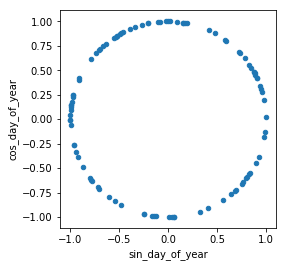

In [6]:
%matplotlib inline

df.sample(100).plot.scatter('sin_day_of_year','cos_day_of_year').set_aspect('equal')

* Split into Xtrain, Xtest, ytrain, ytest based on date
  * Training dates = 2013-01-01 to 2017-09-08
  * Test dates = 2017-09-09 to 2018-04-30
    * Coincides with dockless pilot

In [7]:
train = df.loc['2013-01-01':'2017-09-08']
test = df.loc['2017-09-09':'2018-04-30']
print(train.shape, test.shape)

tr = train.shape[0]
te = test.shape[0]
trpct = tr/(tr+te)
tepct = te/(tr+te)

print("{:0.3f} percent of the data is in the training set and {:0.3f} percent is in the test set".format(trpct, tepct))

(1712, 22) (234, 22)
0.880 percent of the data is in the training set and 0.120 percent is in the test set


In [8]:
# Specify columns to keep and drop for X and y
drop_cols = ['date', 'day_of_year']
y_cols = ['cabi_trips_wdc_to_wdc', 'cabi_trips_wdc_to_wdc_casual']

feature_cols = [col for col in df.columns if (col not in y_cols) & (col not in drop_cols)]

# X y split
Xtrain_raw = train[feature_cols]

# Our target variable here is all DC to DC trips
ytrain = train[y_cols[0]]
Xtest_raw = test[feature_cols]
ytest = test[y_cols[0]]
print(Xtrain_raw.shape, ytrain.shape, Xtest_raw.shape, ytest.shape)

(1712, 18) (1712,) (234, 18) (234,)


## 1. Preprocessing

We want to use PolynomialFeatures and StandardScaler in a Pipeline, but we only want to scale continuous features.

Here, I do the polynomial transformation first and then feed it through a pipeline because I wasn't able to get it all working in one pipeline.

* Use PolynomialFeatures to create quadratic and interaction terms
  * Convert back to DataFrame
  * Drop redundant variables
* Use Pipeline and FeatureUnion to selectively scale/ignore certain variables
* Fit and transform using pipeline to get final Xtrain and Xtest

In [9]:
# Imports and custom classes
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

class Columns(BaseEstimator, TransformerMixin):
    """ 
    This is a custom transformer for splitting the data into subsets for FeatureUnion.
    """
    def __init__(self, names=None):
        self.names = names

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X):
        return X[self.names]
    

In [10]:
# Use PolynomialFeatures to create quadratic and interaction terms
# Should ultimately be part of a Pipeline, but I had issues because 
# PF returns an array and Columns requires a df

pf = PolynomialFeatures(2, include_bias=False)

Xtrain_pf_array = pf.fit_transform(Xtrain_raw)
Xtest_pf_array = pf.transform(Xtest_raw)

# Get feature names 
Xtrain_cols = pf.get_feature_names(Xtrain_raw.columns)

# Convert arrays to dfs with the new pf column names
Xtrain_pf = pd.DataFrame(Xtrain_pf_array, columns=Xtrain_cols)
Xtest_pf = pd.DataFrame(Xtest_pf_array, columns=Xtrain_cols)

print(Xtrain_pf.shape, Xtest_pf.shape)

(1712, 189) (234, 189)


In [11]:
# Dropping squared dummies and nonsensical interaction terms
# This part can be expanded. There's a lot of noise after PF

to_drop = [
    'rain^2', 'snow^2', 'us_holiday^2', 'nats_single^2', 'nats_double^2', 
    'dc_bike_event^2', 'sin_day_of_year^2', 'cos_day_of_year^2',
    'sin_day_of_year cos_day_of_year'
]

Xtrain_pf2 = Xtrain_pf.drop(labels=to_drop, axis=1)
Xtest_pf2 = Xtest_pf.drop(labels=to_drop, axis=1)

print(Xtrain_pf2.shape, Xtest_pf2.shape)

(1712, 180) (234, 180)


In [12]:
# Defining binary and continuous variables
# We have normal 0,1 binary variables, binary variables outside 0,1 that were created by PF, and continuous variables
# We want to MinMaxScale the binary variables and StandardScale the continuous variables

binary = [col for col in Xtrain_pf2.columns if Xtrain_pf2[col].nunique() == 2]
cont = [col for col in Xtrain_pf2.columns if col not in binary]

# FeatureUnion in our pipeline shifts the ordering of the variables so we need to save the ordering here
cols = binary + cont

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('binary', Pipeline([
            ('bincols', Columns(names=binary)),
            ('minmax', MinMaxScaler())
        ])),
        ('continuous', Pipeline([
            ('contcols', Columns(names=cont)),
            ('scaler', StandardScaler())
        ]))
    ]))   
])

In [13]:
# Fit and transform to create our final Xtrain and Xtest

pipeline.fit(Xtrain_pf2)
Xtrain_scaled = pipeline.transform(Xtrain_pf2)
Xtest_scaled = pipeline.transform(Xtest_pf2)

# Put everything back into dfs
Xtrain = pd.DataFrame(Xtrain_scaled, columns=cols)
Xtest = pd.DataFrame(Xtest_scaled, columns=cols)
print(Xtrain.shape, Xtest.shape)

(1712, 180) (234, 180)


In [14]:
# Check to see if the transforms worked as intended

Xtrain.describe(percentiles=[.5]).round(3).transpose()

,count,mean,std,min,50%,max
rain,1712.0,0.455,0.498,0.000,0.000,1.000
snow,1712.0,0.043,0.203,0.000,0.000,1.000
us_holiday,1712.0,0.029,0.167,0.000,0.000,1.000
nats_single,1712.0,0.216,0.411,0.000,0.000,1.000
nats_double,1712.0,0.007,0.083,0.000,0.000,1.000
dc_bike_event,1712.0,0.013,0.113,0.000,0.000,1.000
rain us_holiday,1712.0,0.008,0.090,0.000,0.000,1.000
rain nats_single,1712.0,0.110,0.313,0.000,0.000,1.000
rain nats_double,1712.0,0.004,0.064,0.000,0.000,1.000
rain dc_bike_event,1712.0,0.008,0.087,0.000,0.000,1.000


## 2. Model Fitting

* Define functions for scoring
* Score model using 5-fold cross-validation
* Fit on training data and predict on test data
  * Check residuals and prediction error graphs (yellowbrick)
* Plot predicted values vs actuals (yhat, ytest) 
* Calculate and plot residuals (ytest - yhat) 


In [15]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import median_absolute_error as medae
from sklearn.metrics import explained_variance_score as evs
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [16]:
def cv_score(model, n_splits=5):
    """
    Evaluates a model by 5-fold cross-validation and prints mean and 2*stdev of scores.
    Shuffles before cross-validation but sets random_state=7 for reproducibility.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=7)
    scores = cross_val_score(model, Xtrain, ytrain, cv=kf, 
                             scoring=None, 
                             n_jobs=-1, verbose=3)
    print(scores)
    print("R^2: {:0.3f} (+/- {:0.3f})".format(scores.mean(), scores.std() * 2))
    
def score_model(model):
    """ 
    Fits a model using the training set, predicts using the test set, and then calculates 
    and reports goodness of fit metrics and alpha.
    """
    model.fit(Xtrain, ytrain)
    yhat = model.predict(Xtest)
    r2 = r2_score(ytest, yhat)
    me = mse(ytest, yhat)
    ae = mae(ytest, yhat)
    mede = medae(ytest, yhat)
    ev = evs(ytest, yhat)
    print("Results from {}: \nr2={:0.3f} \nMSE={:0.3f} \
          \nMAE={:0.3f} \nMEDAE={:0.3f} \nEVS={:0.3f} \nalpha={:0.3f}".format(model, r2, me, ae, mede, ev, model.alpha_))


* Specify hyperparameters
* Instantiate model
* Score model by 5-fold cross-validation

In [17]:
from sklearn.linear_model import LassoCV

# Alphas to search over
# Our alpha is usually in the low double digits
# So, we set our search space to 250 steps between 10^0=1 and 10^2=100
alphas = np.logspace(0, 2, 250)

# Instantiate model
cv = KFold(n_splits=5, shuffle=True, random_state=7)
lasso = LassoCV(alphas=alphas, n_alphas=250, fit_intercept=True, normalize=False,
                cv=cv, tol=0.0001, n_jobs=-1, verbose=1)

# Cross-validation
cv_score(lasso)

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.9s remaining:   13.4s


[0.86232617 0.85318826 0.81864751 0.87064274 0.85521213]
R^2: 0.852 (+/- 0.036)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.5s finished


Which variables were selected?

In [18]:
lasso.fit(Xtrain, ytrain)

# Put coefficients and variable names in df
lassodf = pd.DataFrame(lasso.coef_, index=Xtrain.columns)

# Select nonzeros
results = lassodf[(lassodf.T != 0).any()]

# Sort by magnitude
results['sorted'] = results[0].abs()
results.sort_values(by='sorted', inplace=True, ascending=False)

print("Lasso chooses {} variables".format(len(results)))
print(results)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Lasso chooses 75 variables
                                                      0       sorted
apparenttemperaturehigh dc_pop              2405.219153  2405.219153
dc_pop cos_day_of_year                     -2262.647303  2262.647303
daylight_hours cos_day_of_year              1422.892761  1422.892761
apparenttemperaturehigh sin_day_of_year     1258.533721  1258.533721
visibility cos_day_of_year                 -1253.922308  1253.922308
apparenttemperaturehigh^2                  -1247.655201  1247.655201
apparenttemperaturehigh cos_day_of_year     1115.493109  1115.493109
humidity precipprobability                 -1002.568067  1002.568067
visibility sin_day_of_year                  -734.784430   734.784430
precipprobability visibility                 589.837592   589.837592
humidity sin_day_of_year                    -525.723641   525.723641
precipprobability^2                         -351.386628   351.386628
dc_pop                                       338.553238   338.553238
dayligh

C:\Users\slbau\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\slbau\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\slbau\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellAp

How does our model perform on the test data?

In [19]:
score_model(lasso)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Results from LassoCV(alphas=array([  1.     ,   1.01867, ...,  98.16753, 100.     ]),
    copy_X=True, cv=KFold(n_splits=5, random_state=7, shuffle=True),
    eps=0.001, fit_intercept=True, max_iter=1000, n_alphas=250, n_jobs=-1,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=1): 
r2=0.819 
MSE=1830937.830           
MAE=1031.378 
MEDAE=744.195 
EVS=0.819 
alpha=4.557


C:\Users\slbau\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


What do our residuals look like?

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

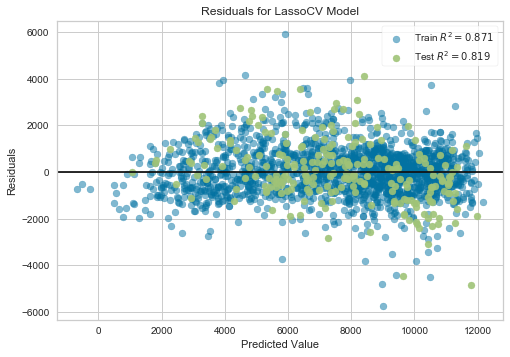

In [20]:
from yellowbrick.regressor import ResidualsPlot

resplot = ResidualsPlot(lasso)

resplot.fit(Xtrain, ytrain)
resplot.score(Xtest, ytest)
g = resplot.poof()

What does our prediction error look like?

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

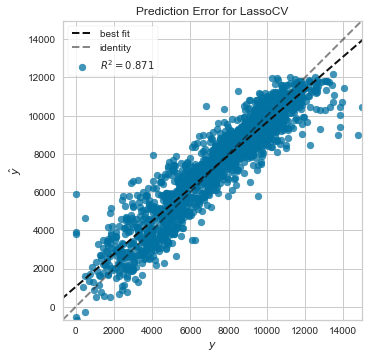

In [21]:
from yellowbrick.regressor import PredictionError

prederr = PredictionError(lasso)

prederr.fit(Xtrain, ytrain)
prederr.score(Xtrain, ytrain)
g = prederr.poof()

Next, we pull out our fitted values (yhat) and actuals (ytest) to see how they compare.

We also calculate our residuals by subtracting our fitted values from the actuals.

TODO: 
* May want to replace t with actual date - pull out from index?
* See if seaborn.tsplot offers better options

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

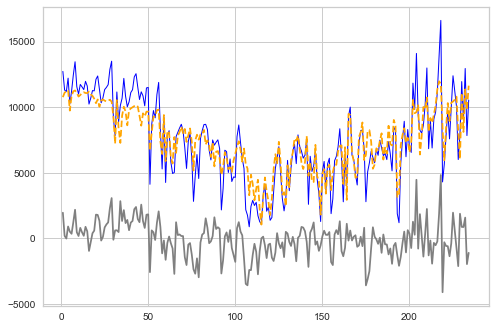

In [22]:
import matplotlib.pyplot as plt

lasso.fit(Xtrain, ytrain)

yhat = lasso.predict(Xtest)
resid = ytest - yhat

data = pd.DataFrame({'t': range(1, len(yhat) + 1), 
                     'ytest': ytest, 
                     'yhat': yhat,
                     'resid': resid})

plt.plot('t', 'ytest', data=data, marker='', color='blue', linewidth=1, label='actual')
plt.plot('t', 'yhat', data=data, marker='', color='orange', linestyle='dashed', label='predicted')
plt.plot('t', 'resid', data=data, marker='', color='gray')
plt.show()

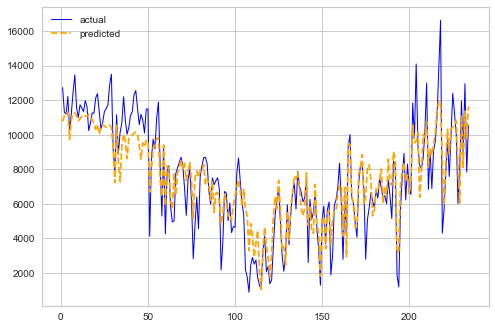

In [23]:
plt.plot('t', 'ytest', data=data, marker='', color='blue', linewidth=1, label='actual')
plt.plot('t', 'yhat', data=data, marker='', color='orange', linestyle='dashed', label='predicted')
plt.legend()

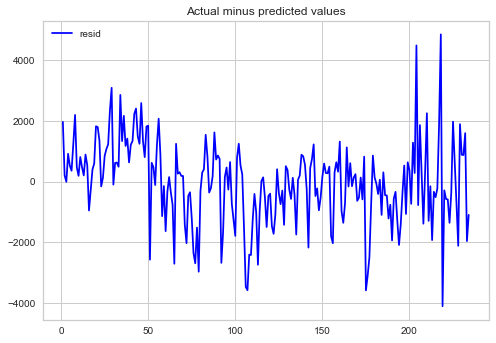

In [24]:
plt.title('Actual minus predicted values')
plt.plot('t', 'resid', data=data, marker='', color='blue')
plt.legend()

In [25]:
end_time = (time.perf_counter() - start_time)/60
print("This notebook took {:0.2f} minutes to run".format(end_time))

This notebook took 0.61 minutes to run


To do:
* Explore yellowbrick/charts further
* Refine plots
* Duplicate for casual riders
* Change 'tol' in LassoCV to avoid ConvergenceWarnings
* Try neg-MSE as scoring method?
  * May be a better fit, but harder to interpret since it's relative